In [424]:
import cv2
from imutils.perspective import four_point_transform
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow

In [425]:
# Отображение картинки
def cv2_show(name, img):
#  cv2.imshow(name, img) # Для компа
  cv2_imshow(img) # Для колаба
  cv2.waitKey(0)
  cv2.destroyAllWindows()

In [426]:
def preprocess_image(image, blur = 1.1, black_threshold=120, ratio=0.4):
  """
  Предварительная обработка изображения.
  1) Масштабирование, до размеров с минимальной стороной scale_to пикселей
  :param image: Входное изображение;
  :param blur: Определяет степень размытия (стандартное отклонение ядра);
  :param black_threshold: порог чёрного цвета (меньше - черные, больше - белые)
  :ratio - коэффициент масштабирования
  """
  # Отдельно готовим картинку для морфологического поиска по маске
  # перевод изображения в оттенки серого
  bw_result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # размываем
  bw_result = cv2.GaussianBlur( src=bw_result, ksize=(0,0), sigmaX=blur)
  cv2_show('',bw_result)

  # перевод изображения в черно-белый вариант
  bw_result = cv2.threshold(bw_result, black_threshold, 255, cv2.THRESH_BINARY)[1]
  cv2_show('',bw_result)

  # Масштабирвоание изображения Масштабирование после преобразований дает лучший результат для поиска по маске
  bw_result = cv2.resize(bw_result, None, fx=ratio, fy=ratio)

  # Инвертируем изображение - обеспечивает уверенное обнаружение квадрата с черным контуром и белой серединой
  bw_result = 255 - bw_result
  cv2_show('', bw_result)

  return bw_result

In [427]:
scale_to = 800 # для масштабирования до размеров с минимальной стороной scale_to пикселей
black_threshold=120 # порог чёрного цвета (меньше - черные, больше - белые)
orig_img = cv2.imread('photo_2023-11-10_15-42-33_90cw.jpg')
if orig_img.shape[1]>orig_img.shape[0]:
  orig_img = cv2.rotate(orig_img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
print(orig_img.shape)

# Нахождение коэффициента масштабирования
ratio = scale_to/min(orig_img.shape[:2])
bw_img = preprocess_image(orig_img, blur=1.1, black_threshold=black_threshold, ratio=ratio)

Output hidden; open in https://colab.research.google.com to view.

In [428]:
def find_black_square(image, kernel_size=5, iterations = 3):
  """
  Поиск маски квадратов с помощью математической морфологии.
  Возвращается маска, где белые области - квадраты, черные - фон.
  :param image: Входное изображение, ожидается что оно чёрно-белое.
  :param kernel_size: Размер ядра для выполнения математического закрытия.
  """
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
  result = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
  result = 255 - result
  cv2_show('', result)
  return result

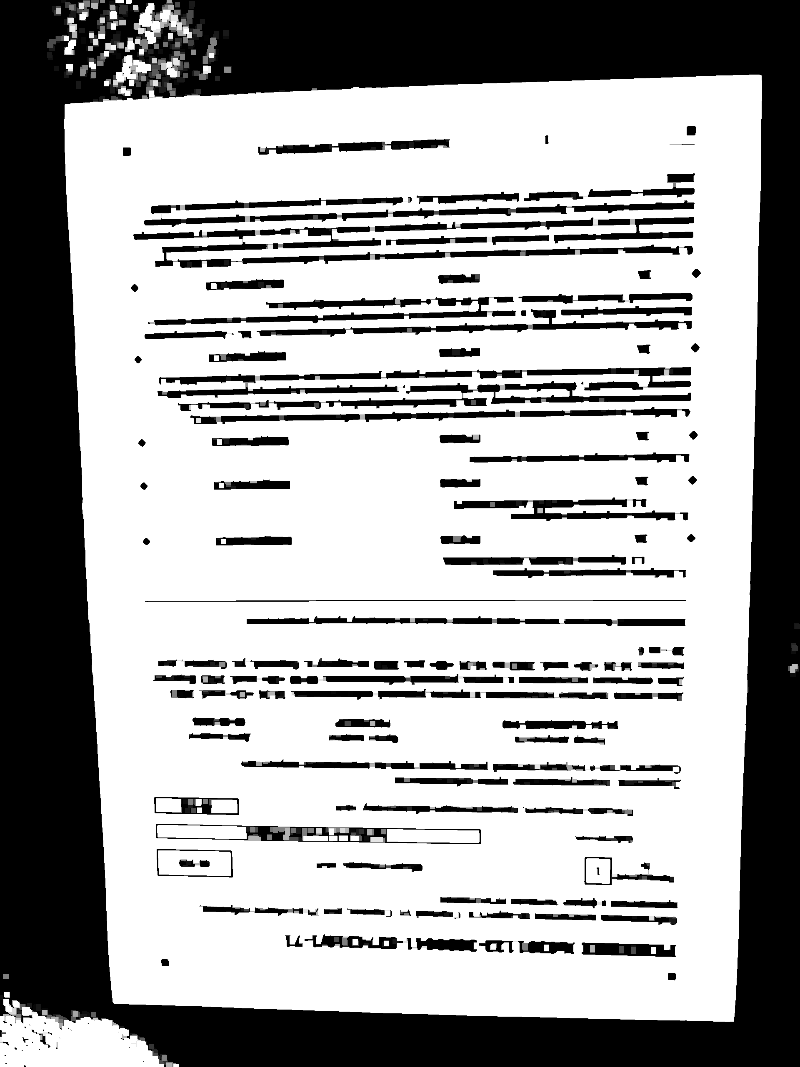

In [429]:
mask_img = find_black_square(image=bw_img, kernel_size=3, iterations=2) # Итерации можно увеличить до 3-х

In [430]:
def visualize(image_src, coords, radius=5, thickness=1, color=(0, 255, 0), relative=True):
  """
  Визуализация координат
  :param image_src: Исходное изображение
  :param coords: Координаты
  :param radius: Размер кружочков для отрисовки
  :param thickness: Толщина кружности, -1 - заливка
  :param color: Цвет кружочка
  :param relative: Относительные ли координаты используются
  :return: Изображение с отмеченными центрами чёрных квадратов.
  """

  vis = image_src.copy()
  if len(coords) == 0:
    return vis
  if relative:
    # Привести относительные координаты в абсолютные
    coords = (coords * image_src.shape[:2][::-1]).astype(np.int32)
  coords = coords.astype(np.int32)
  # Отрисовать кружочки в найденных центрах квадратов
  ln = radius
  for c in coords:
    # cv2.circle(vis, tuple(c), radius, color, thickness)
    cv2.line(vis, (c[0]-ln, c[1]), (c[0]+ln, c[1]), color, thickness=thickness)
    cv2.line(vis, (c[0], c[1]-ln), (c[0], c[1]+ln), color, thickness=thickness)
  return vis

In [431]:
def get_contours(mask_image, color_img, area_threshold_min = 50, area_threshold_max=120, relative=True):# 50,120
  """
  Нахождение относительных координат объектов
  Поиск выполняется по маске, где белые области - квадраты, черные - фон.
  Возвращается numpy массив с координатами квадратов.
  :param image_mask: Входная маска.
  :param area_threshold: Порог по для фильтрации слишком больших объектов.
  :param relative: Возвращать относительные или абсолютные координаты.
  """
  # Найти все контуры фигур
  contours = cv2.findContours(mask_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Можно попробовать cv2.RETR_LIST
  contours = contours[0] if len(contours) == 2 else contours[1]
  centers = []
  for c in contours:
    delta = np.abs( np.max(c, axis=0) - np.min(c, axis=0)) # Находим разницу между максимальным и минимальным значениями по каждой оси
    ddelta = abs(delta[:,0]-delta[:,1]) # Разница между дельтами по х и по y (для квадрата = 0)
    if (ddelta<3 and delta > 4).all() and (delta < 13).all() and cv2.contourArea(c) > area_threshold_min and cv2.contourArea(c) < area_threshold_max:#3,5,12
      center = np.mean([np.max(c, axis=0), np.min(c, axis=0)], axis=0)[0]
      color = color_img[int(center[1]), int(center[0])]
      c_delta = np.abs( np.max(color, axis=0) - np.min(color, axis=0)) # Находим разницу между максимальным и минимальным значениями по каждой оси
      if c_delta<30: # Если разброс между каналами превышает заданный предел, есть цвет, значит это не лист
        # print('color:', color, '   color delta:', c_delta, '   center:', center)
        centers.append (center)

  if len(centers) > 3:
    centers = np.array(centers)[[0,1,-2,-1]] # Если найдено больше 3-х центров, берем 1, 2, предпоследний и последний
  else:
    return []

  # Сортируем точки
  result = []
  for i in range(len(centers)):
    print(centers[i])
  if centers[0][0,]<centers[1][0,]:
    result.append(centers[0])
    result.append(centers[1])
  else:
    result.append(centers[1])
    result.append(centers[0])
  if centers[2][0,]<centers[3][0,]:
    result.append(centers[3])
    result.append(centers[2])
  else:
    result.append(centers[2])
    result.append(centers[3])
  centers = np.array(result)
  # centers = np.array(centers)
  # print('centers', centers)

  is_rotate_180 = False
  if np.mean(color_img[int(centers[1][1]), int(centers[1][0])]) > black_threshold: # Если цвет в центре второго маркера ближе к белому, значит нужно поворачивать на 180
    is_rotate_180 = True

  if relative:
    centers[:, 0] = centers[:, 0] / mask_image.shape[1]
    centers[:, 1] = centers[:, 1] / mask_image.shape[0]

  return [centers, is_rotate_180]#, area


[671.5 976. ]
[164.5 962. ]
[126.5 151.5]
[691. 130.]
4


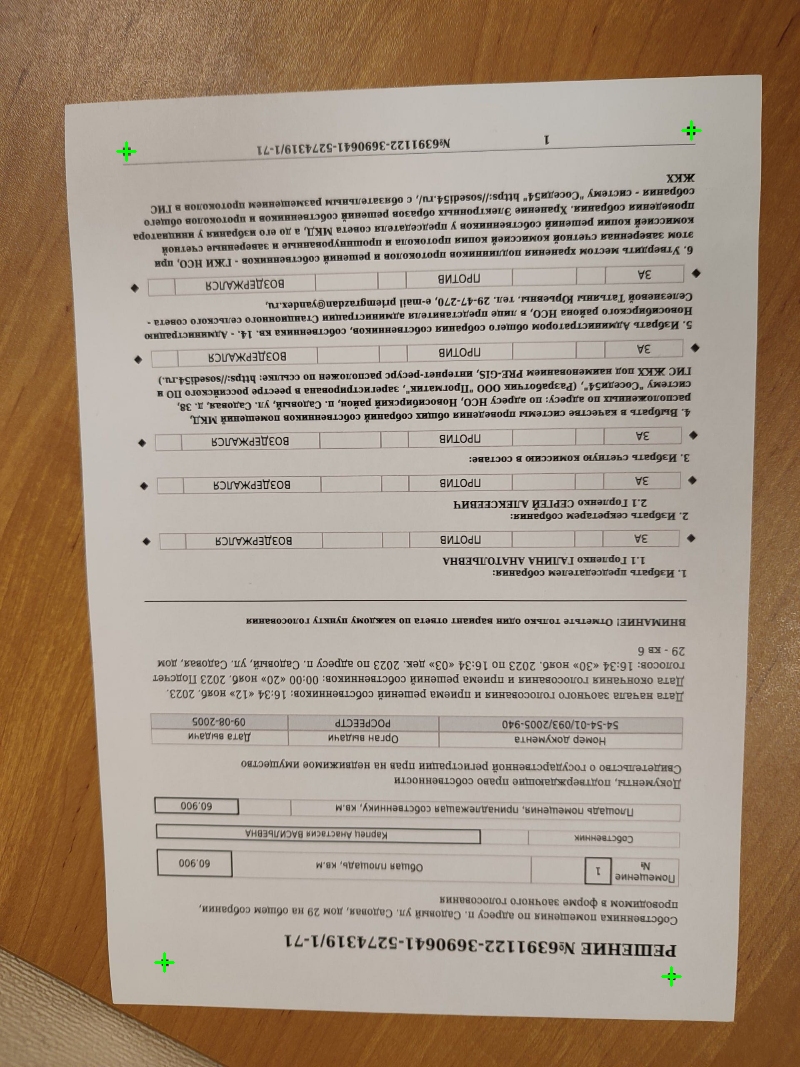

In [432]:
resize_img=cv2.resize(orig_img, None, fx=ratio, fy=ratio)
coords, is_rotate_180 = get_contours(mask_image=mask_img, color_img=resize_img, relative=False)
print(len(coords))

vis_image = visualize(resize_img, coords, 9, 2, (0, 255, 0), relative=False) # Рисуем найденный контур, -1 означает залить
cv2_show('', vis_image)

In [433]:
# Пробное преобразование перспективы - (снизу обрезаются цифры номера)
wraped_img = four_point_transform(orig_img, coords.astype(np.int32)/ratio)
# Если нужно, поворачиваем изображение
if (is_rotate_180):
  wraped_img=cv2.rotate(wraped_img, rotateCode=cv2.ROTATE_180)
# Показываем результат
cv2_show('wrap',wraped_img)

Output hidden; open in https://colab.research.google.com to view.

In [434]:
# Поскольку номер внизу обрезается, нужно добавить приращения вниз на l пикселей (для оригинала)
# Для этого нужно найти координаты нижних маркеров со смещением и с учетом искажения фото
def get_offset_point(x1, y1, x2, y2, s=783.37, l=5, is_rotate_180=False):
  '''
    Функция вычисления координаты точки со смещением
    x1, y1 - координаты нижнего угла
    x2, y2 - координаты верхего угла (с той же стороны листа)
    s - расстояние между центрами верхнего и нижнего маркеров в образцовом PDF
    l - приращение в пикселях для оригинального PDF (чтобы смещение вниз захватило номер бюллетеня)
    is_rotate_180 - требуется ли поворот листа на 180 град. (True - приращение будет рассчитано вверх, False - вниз)
  '''
  # Расстояние между точками
  h = ((x1-x2)**2 + (y1-y2)**2)**0.5
  # Приращение с учетом соотношения оригинального и текущего расстояния между маркерами
  l = l*h/s
  # Коэффициент приращения
  k = l/h
  # Находим координаты с учетом приращения и необходим ли поворот на 180
  if is_rotate_180:
    x = x2+(x2-x1)*k
    y = y2+(y2-y1)*k
  else:
    x = x1+(x1-x2)*k
    y = y1+(y1-y2)*k
  return [x,y]

In [435]:
# Расчет приращения для устранения обрезки нижнего номера бюллетеня
if (is_rotate_180):
  coords[3][0], coords[3][1] = get_offset_point(coords[0][0], coords[0][1], coords[3][0], coords[3][1], is_rotate_180=is_rotate_180)
  coords[2][0], coords[2][1] = get_offset_point(coords[1][0], coords[1][1], coords[2][0], coords[2][1], is_rotate_180=is_rotate_180)
else:
  coords[0][0], coords[0][1] = get_offset_point(coords[0][0], coords[0][1], coords[3][0], coords[3][1], is_rotate_180=is_rotate_180)
  coords[1][0], coords[1][1] = get_offset_point(coords[1][0], coords[1][1], coords[2][0], coords[2][1], is_rotate_180=is_rotate_180)

# Восстанавливаем геометрию до прямоугольника с обрезкой по центрам маркеров и с учетом приращения
wraped_img = four_point_transform(orig_img, coords.astype(np.int32)/ratio)

# Если нужно, поворачиваем изображение
if (is_rotate_180):
  # orig_img=cv2.rotate(orig_img, rotateCode=cv2.ROTATE_180)
  wraped_img=cv2.rotate(wraped_img, rotateCode=cv2.ROTATE_180)

# Показываем и сохраняем результат
cv2_show('wrap',wraped_img)
# wraped = cv2.cvtColor(wraped, cv2.COLOR_BGR2GRAY)
# cv2_show('wrap2',wraped)
# ref = cv2.threshold(wraped, 120, 255, cv2.THRESH_BINARY)[1]
# cv2_show('ref',ref)
# cv2_show('result.jpg', ref)

Output hidden; open in https://colab.research.google.com to view.